# Multimodal omics Python framework | muon

`muon` is designed around **MuData** (multimodal data) objects — in the same way that `scanpy` and `AnnData` are built to work primarily with scRNA-seq data in Python.  
Individual modalities in `MuData` are naturally represented using `AnnData` objects.

**MUON: multimodal omics analysis framework**  
*Danila Bredikhin, Ilia Kats, Oliver Stegle*  
*Genome Biology (2022, Feb 01). doi: [10.1186/s13059-021-02577-8](https://doi.org/10.1186/s13059-021-02577-8)*

We will use an HDF5 file containing gene and peak counts as input. In addition to that, when loading this data, muon will look for default files like atac_peak_annotation.tsv and atac_fragments.tsv.gz in the same folder and will load peak annotation table and remember the path to the fragments file if they exist.

In [2]:
# Import necesarry packages
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import muon as mu
import mudatasets

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import multimodal data from 10X Genomics 
#muon will look for default files like atac_peak_annotation.tsv and atac_fragments.tsv.gz 
#in the same folder and will load peak annotation table and 
#remember the path to the fragments file if they exist.

# Set data path
import os
data_path = "/Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid"

# Load 10x multiome HDF5
mdata = mu.read_10x_h5(os.path.join(data_path, "filtered_feature_bc_matrix.h5"))
#mdata = muon.read_10x_h5("/Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()

# Individual assays are stored as AnnData object
# which enables the use of all the default scanpy functionality per assay
rna = mdata.mod["rna"]
atac = mdata.mod["atac"]

# Alternatively
# from muon import MuData
#mdata = MuData({'rna': adata_rna, 'atac': adata_atac})

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/filtered_feature_bc_matrix.h5


/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/mudata/_co

Added peak annotation from /Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/atac_fragments.tsv.gz


In [4]:
# reads were mapped by ATAC
mdata.mod["atac"].var_names

# what does multiomics data look like
mdata

MuData object with n_obs × n_vars = 8656 × 283484
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	8656 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	8656 x 246883
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

# Processing individual modalities

## Individual analysis of scRNA-seq data 
- Feature selection
- 2D embedding (e.g., UMAP or t-SNE)
- Cell type annotation (no integration across samples needed)
  
pretty much followed the scRNAseq tutorial + the [muon-tutorials/single-cell-rna-atac/brain3k
/](https://github.com/scverse/muon-tutorials/blob/master/single-cell-rna-atac/brain3k/1-Processing-and-Integration.ipynb)

### scRNAseq Quality control

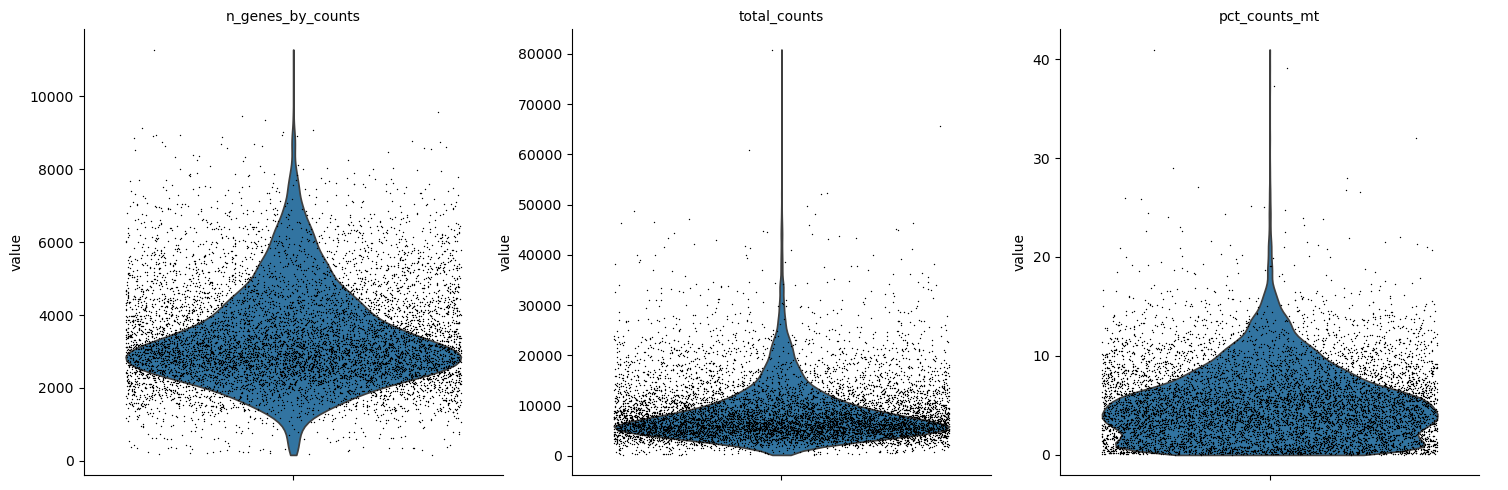

<Figure size 640x480 with 0 Axes>

In [15]:
# Calculate QC metrics for mitochondrial genes
rna.var["mt"] = rna.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(rna, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# Visualise to identofy where to set the thresholds for QC
sc.pl.violin(rna, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

In [56]:
print(f"Before: {rna.n_obs} cells")
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 1000) & (x < 7500))
print(f"(After n_genes: {rna.n_obs} cells)")
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 40000)
print(f"(After total_counts: {rna.n_obs} cells)")
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 30)
print(f"After: {rna.n_obs} cells")

Before: 8618 cells
(After n_genes: 8460 cells)
(After total_counts: 8460 cells)
After: 8460 cells


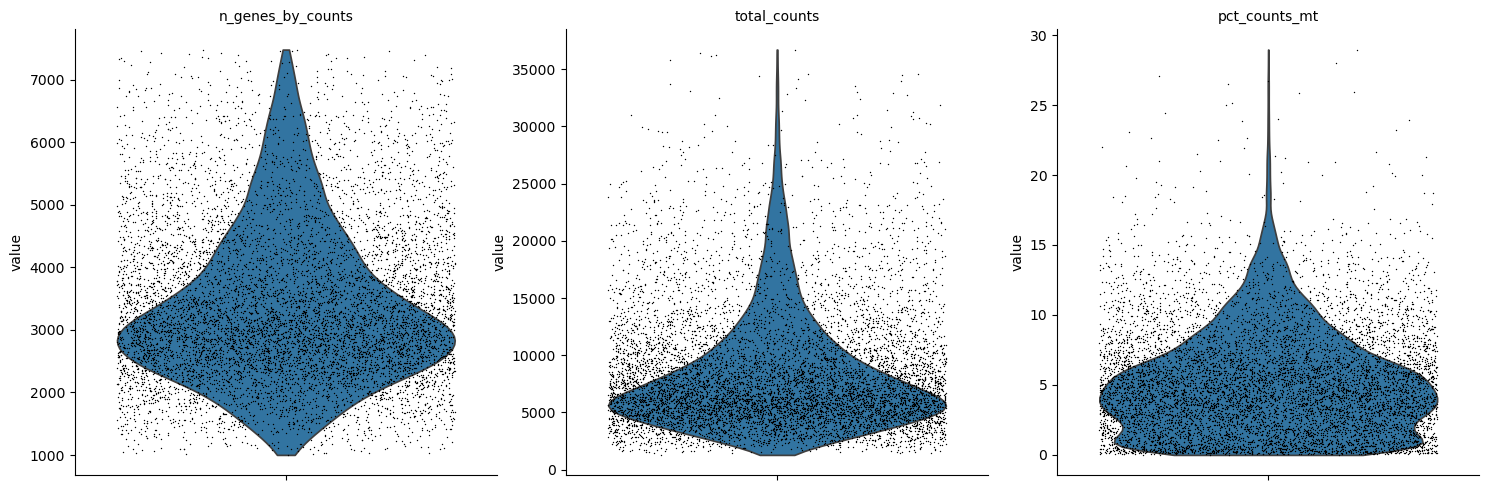

In [57]:
# Let's see how the data looks after filtering:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [58]:
# # Make a copy of the raw count matrix into the layer slot, 
# in case the raw counts may be useful at some point
rna.layers["counts"] = rna.X.copy()

# Perform normalisation
sc.pp.normalize_total(rna, target_sum=1e4)

# Perfor log transformation
sc.pp.log1p(rna)
rna.raw = rna
rna.layers["lognorm"] = rna.X.copy()

### Define informative features

In [69]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5, n_top_genes=3000)

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


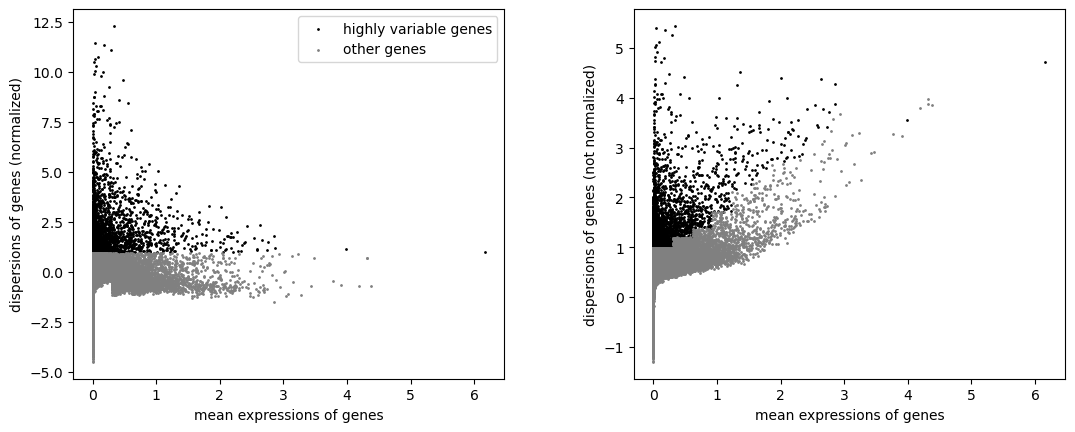

In [70]:
sc.pl.highly_variable_genes(rna)

In [71]:
# How many variable genes are there
np.sum(rna.var.highly_variable)

np.int64(3000)

### Scaling (optional) and PCA

We focus on 3000 highly variable genes. 

In [72]:
# Scaling of data to regress out unwanted sources of variation from gene expression
rna_for_scaling = rna
rna_for_scaling.layers['lognorm'] = rna_for_scaling.X.copy()
rna_for_scaling.raw = rna_for_scaling
rna_for_scaling = rna_for_scaling[:,rna_for_scaling.var['highly_variable']]
sc.pp.scale(rna_for_scaling)

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [73]:
sc.tl.pca(rna_for_scaling, svd_solver='arpack')

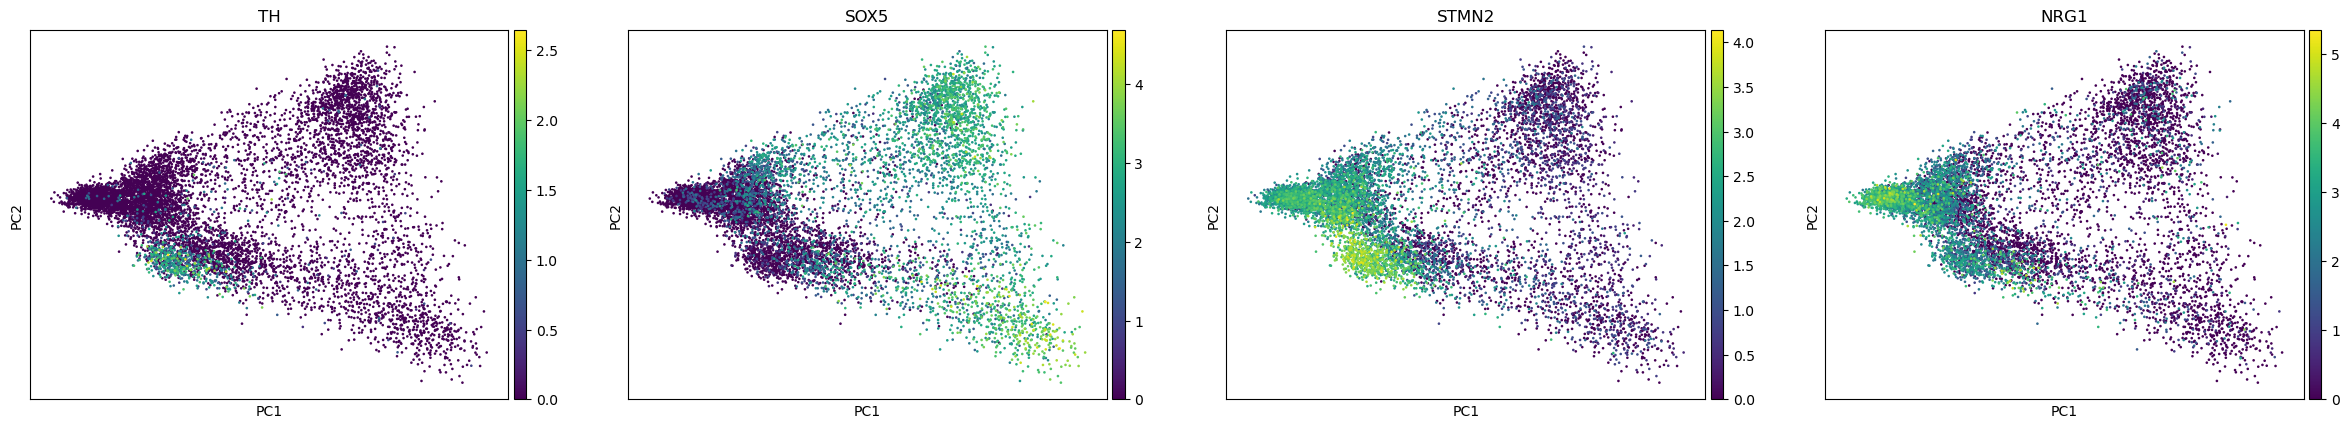

In [85]:
sc.pl.pca(rna_for_scaling, color=["TH", "SOX5", "STMN2", "NRG1"])

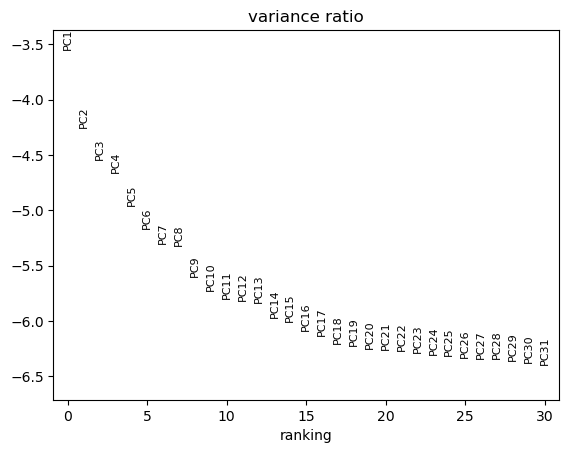

In [76]:
sc.pl.pca_variance_ratio(rna_for_scaling, log=True)

### PCA without scaling

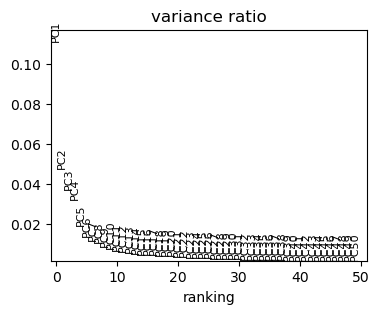

             gene  pc1_loading
6155      ZNF385D     0.161425
1200         NFIA    -0.156682
14535     CNTNAP2     0.154714
21355       PDE3A    -0.151401
21387        SOX5    -0.139735
22430        RFX4    -0.134868
15130        NRG1     0.122731
9147        FSTL5     0.118151
8395        EPHA5     0.113802
14180      PTPRZ1    -0.111123
5522        ERBB4    -0.110311
16410      LINGO2     0.109328
6764        CADM2     0.107654
14341         PTN    -0.106894
17718         VIM    -0.106800
8652        UNC5C     0.106751
7293   AC092957.1    -0.103281
23482      HS6ST3     0.102276
1173         DAB1     0.099133
16303        NFIB    -0.096289


In [84]:
# Use highly variable genes
sc.pp.pca(rna, mask_var='highly_variable')

# Visualise how much variation is captures
with plt.rc_context({'figure.figsize':(4,3)}):
    sc.pl.pca_variance_ratio(rna, n_pcs=50)
    
# Choose the number of PC via the elbow method or something else

pc1_loadings = rna.varm['PCs'][:, 0]  # Loadings for PC1
# Create a DataFrame with genes and their PC1 loadings
pc1_df = pd.DataFrame({
    'gene': rna.var_names,
    'pc1_loading': pc1_loadings
})

# Sort by absolute value of loadings
top_genes = pc1_df.reindex(pc1_df['pc1_loading'].abs().sort_values(ascending=False).index)

# Display top genes
print(top_genes.head(20))  # Top 20 genes contributing to PC1

We proceed with number of PCs = 20. Ans we already see some important genes underlying the data patterns.
Lets go with the unscaled version for now.

### Finding cell neighbours and clustering cells (Leiden)

In [86]:
sc.pp.neighbors(rna, n_pcs=20)

In [92]:
# Perform non-linear dimensionality reduction (UMAP)
sc.tl.umap(rna)

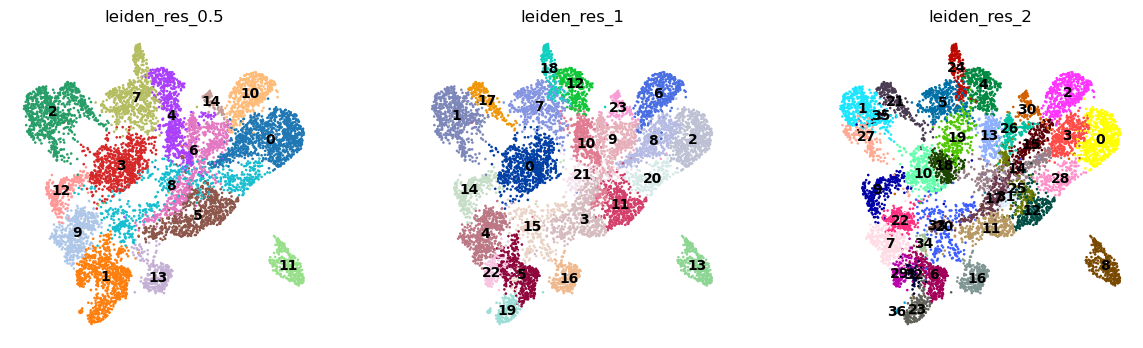

In [93]:
# Try different resolutions
sc.tl.leiden(rna, resolution=0.5, key_added='leiden_res_0.5')
sc.tl.leiden(rna, resolution=1, key_added='leiden_res_1')
sc.tl.leiden(rna, resolution=2, key_added='leiden_res_2')

with plt.rc_context({'figure.figsize':(4,4)}):
    sc.pl.umap(rna, color=['leiden_res_0.5','leiden_res_1','leiden_res_2'], frameon=False, legend_loc='on data')

We proceed with Leiden resolution of 0.5, which gives 14 cell clusters. If we then want to go into more granular clusters, we can increase the resolution and try to annotate. 

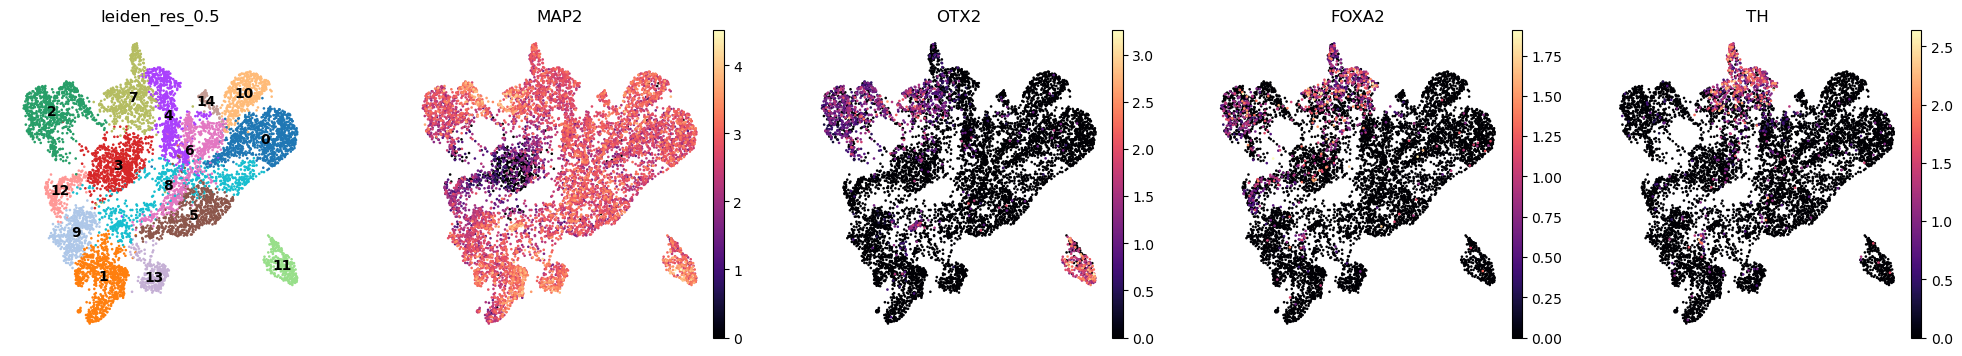

In [128]:
with plt.rc_context({'figure.figsize' : (4,4)}):
    sc.pl.umap(rna, color=["leiden_res_0.5", "MAP2", "OTX2", "FOXA2", "TH"], ncols=5, cmap='magma', frameon=False, legend_loc="on data")

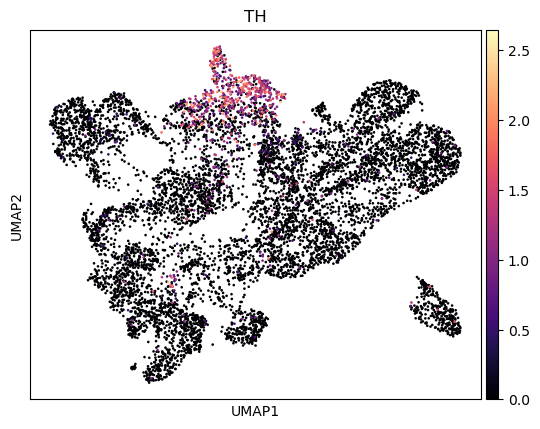

In [100]:
# For generating high resolution plots
sc.pl.umap(rna, color="TH", cmap='magma', legend_loc="on data")

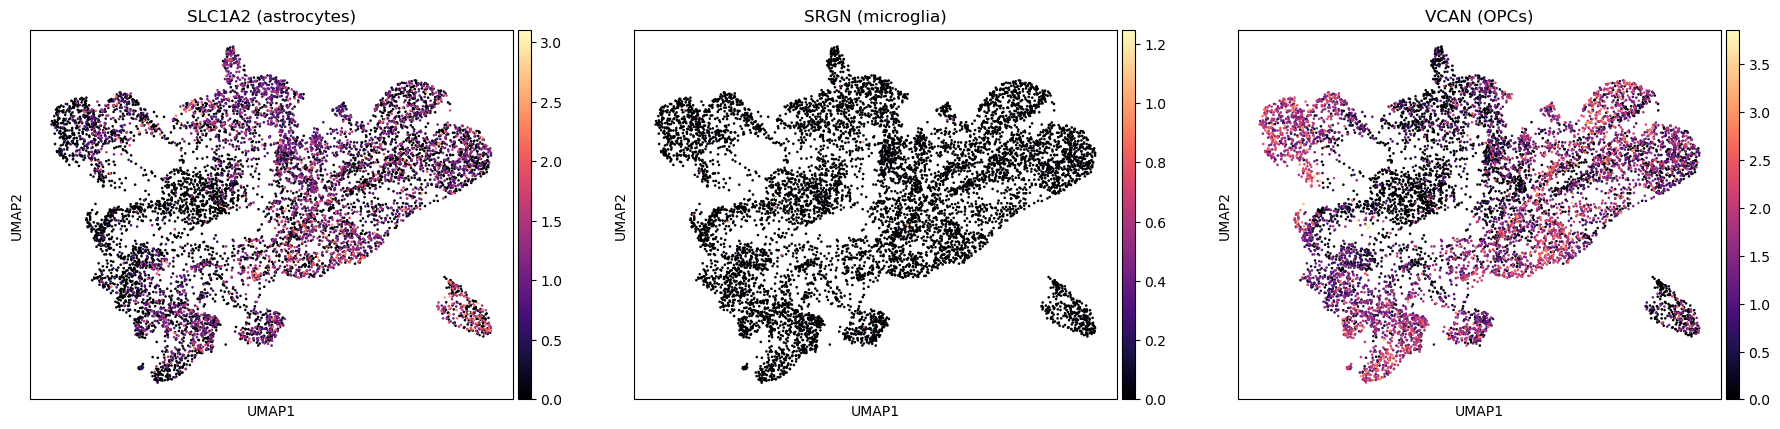

In [105]:
sc.pl.umap(rna, color=["SLC1A2", "SRGN", "VCAN"], cmap='magma',
           title=["SLC1A2 (astrocytes)", "SRGN (microglia)", "VCAN (OPCs)"])

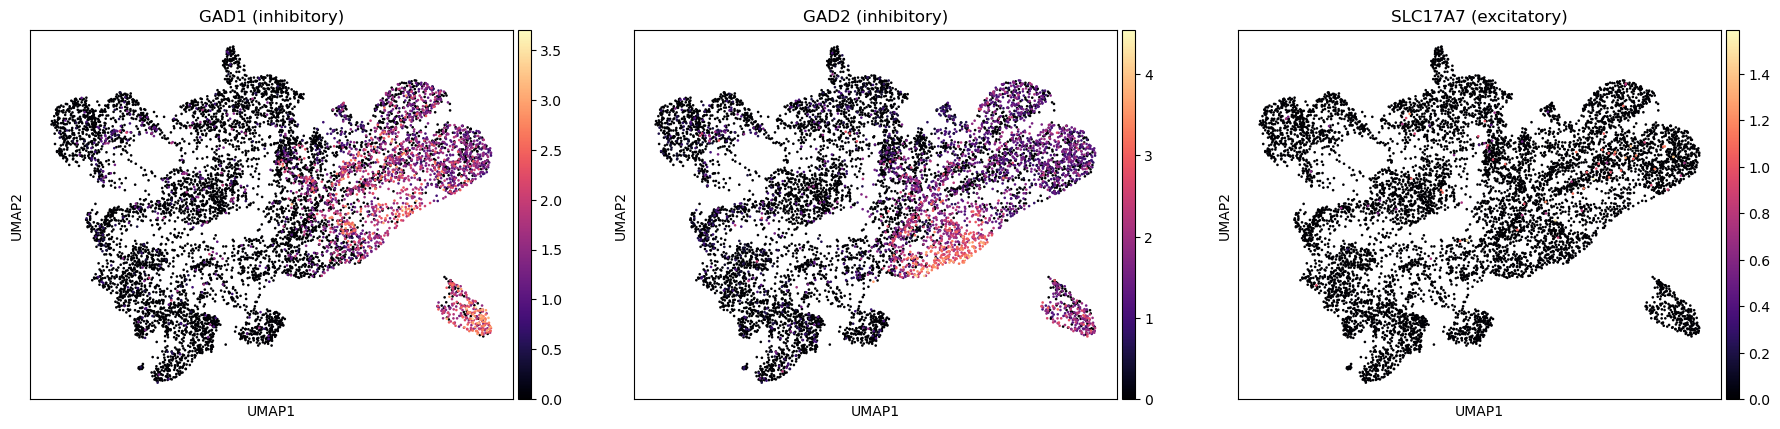

In [106]:
sc.pl.umap(rna, color=["GAD1", "GAD2", "SLC17A7"],cmap='magma',
           title=["GAD1 (inhibitory)", "GAD2 (inhibitory)", "SLC17A7 (excitatory)"])

### Marker genes and celltypes

Next step is to identify signature genes, or marker genes, of each identified cell cluster. Based on the identified cluster marker genes, one can do literature search, enrichment analysis, do experiment, ask people around, or ask LLM models like ChatGPT for annotation; <br>
Lets try to identify signature genes standing behind the clusters ourselves

In [101]:
sc.tl.rank_genes_groups(rna, 'leiden_res_0.5', method='t-test')

In [102]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
# We get for each of the 14 clusters the gene names that are significantly different than the backgrounf and the p values
marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n            0_p         1_n  1_p      2_n            2_p     3_n  \
0  ZNF385D   0.000000e+00  AC092957.1  0.0    SLIT2   0.000000e+00     FTL   
1    NRXN3   0.000000e+00         PTN  0.0    LRP1B   0.000000e+00  ZCCHC7   
2    EPHA5   0.000000e+00      NCKAP5  0.0  PLEKHA5   0.000000e+00   SRP54   
3    FSTL5   0.000000e+00       PDE1A  0.0    PTPRG   0.000000e+00    ARF4   
4    AUTS2   0.000000e+00       PDE3A  0.0     NFIA   0.000000e+00    RNMT   
5     LHX1   0.000000e+00       NTRK2  0.0     TTC6  3.659756e-303   SCFD2   
6      CA8  1.287140e-311         QKI  0.0   ADGRV1  9.962940e-289   DDX18   
7     SOX4   0.000000e+00       ERBB4  0.0   PLXDC2  1.404149e-297  DNAJC3   
8     SYN3  1.976263e-323        SDK1  0.0    RSPO2  4.596956e-261   RPS16   
9    LRRC7   0.000000e+00      MAPK10  0.0   COL4A5  1.689223e-264    P4HB   

             3_p      4_n            4_p      5_n            5_p     6_n  \
0  1.195580e-180    STMN2  7.813941e-278    NRXN1  7.014312e-220    NNAT   
1  1.563787e-161     ANK3  5.384329e-276     ZIC1  1.644762e-196   NRXN1   
2  2.151966e-155     MAPT  7.969615e-218      DCC  3.158487e-193    ANK3   
3  1.287863e-144    NRXN1  3.620374e-253     NFIB  3.208147e-170   PTPRD   
4  5.671229e-128      DCX  4.687840e-207     TCF4  4.121117e-164    SOX4   
5  1.332297e-121    LRRC7  6.544724e-206  ZNF804A  8.260437e-156    MEG3   
6  3.468823e-121   SNHG14  6.450520e-187    SOX11  9.625206e-159   USP9Y   
7  1.277757e-118    BASP1  1.264624e-182     SYT1  1.792017e-162    PBX3   
8  5.244787e-117    NCAM1  1.729412e-195    PTPRD  2.186926e-153  THSD7A   
9  1.385913e-114  FAM155A  1.103618e-175    KLF12  3.235712e-136    EBF1   

             6_p          7_n            7_p      8_n           8_p     9_n  \
0  3.449193e-224        ZFHX3  1.462871e-159   MALAT1  9.296863e-60   NTRK2   
1  2.746617e-182        MAP1B  1.689471e-168   MARCH1  2.494589e-57  PDE10A   
2  7.538289e-168        DSCAM  7.193835e-164   IGFBP2  6.643156e-50     PTN   
3  1.349582e-150        ERBB4  1.953797e-152    DDIT4  2.696420e-47   TFPI2   
4  1.385048e-144  IQCJ-SCHIP1  3.997364e-139     PGK1  3.796083e-46    PON2   
5  3.702974e-126        PTPRO  1.286900e-138    VEGFA  2.717389e-45    SOX5   
6  1.487798e-116        LMX1A  2.060292e-131    MDGA2  1.370809e-42   NOVA1   
7  8.096196e-114        PEG10  2.896000e-130     ENO1  4.066394e-39    NFIA   
8  5.301165e-107         LMO4  2.029956e-119     BTG1  1.536899e-38    RFX4   
9  7.968703e-103        LRP1B  6.814180e-113  FAM162A  5.251310e-38     VIM   

             9_p     10_n           10_p        11_n           11_p    12_n  \
0  6.513129e-235  ZNF385D   0.000000e+00       DSCAM  3.043551e-205     VIM   
1  2.781523e-238     NNAT  8.193560e-287    OTX2-AS1  4.587003e-157    TTC6   
2  2.514719e-219    EPHA5  3.104359e-286       MEIS2  8.451628e-149    RFX4   
3  2.307133e-192    UNC5C  4.647426e-275       ZFPM2  2.429047e-125    CANX   
4  4.622717e-197     SOX4  1.580486e-301        RELN  1.048910e-101    PSAP   
5  8.216978e-204     LHX1  2.412995e-244        SOX4  1.767947e-104    NTN1   
6  2.401132e-203  CNTNAP2  7.036677e-245       TENM3   4.862673e-89  IGFBP5   
7  2.895530e-213    NRXN3  2.598794e-293        GAD1   2.412828e-77  FNDC3B   
8  3.688864e-189    AUTS2  9.992440e-242  AL161757.4   3.691323e-74    NFIA   
9  1.794024e-186    FOXP2  8.719607e-199       CHRM2   1.337611e-71   ANXA2   

            12_p        13_n           13_p     14_n          14_p  
0  3.085527e-152       PDE3A  6.732758e-238  ZNF385D  4.020597e-37  
1   1.571354e-92  AC092957.1  1.226292e-198    AUTS2  3.515020e-30  
2   5.582973e-93       GRID2  3.902585e-217     LHX1  4.240693e-26  
3   7.563337e-92       PRKD3  5.186779e-170    EPHA5  5.951822e-26  
4   3.643320e-92      PDE10A  8.703176e-195    UNC5C  2.584377e-25  
5   2.516438e-82      NCKAP5  1.291546e-155    NRXN3  7.948696e-26  
6   1.866680e-80        SDK1  1.126744e-158  CNTNAP2  1.146843e-24  
7   2.428514e-84   

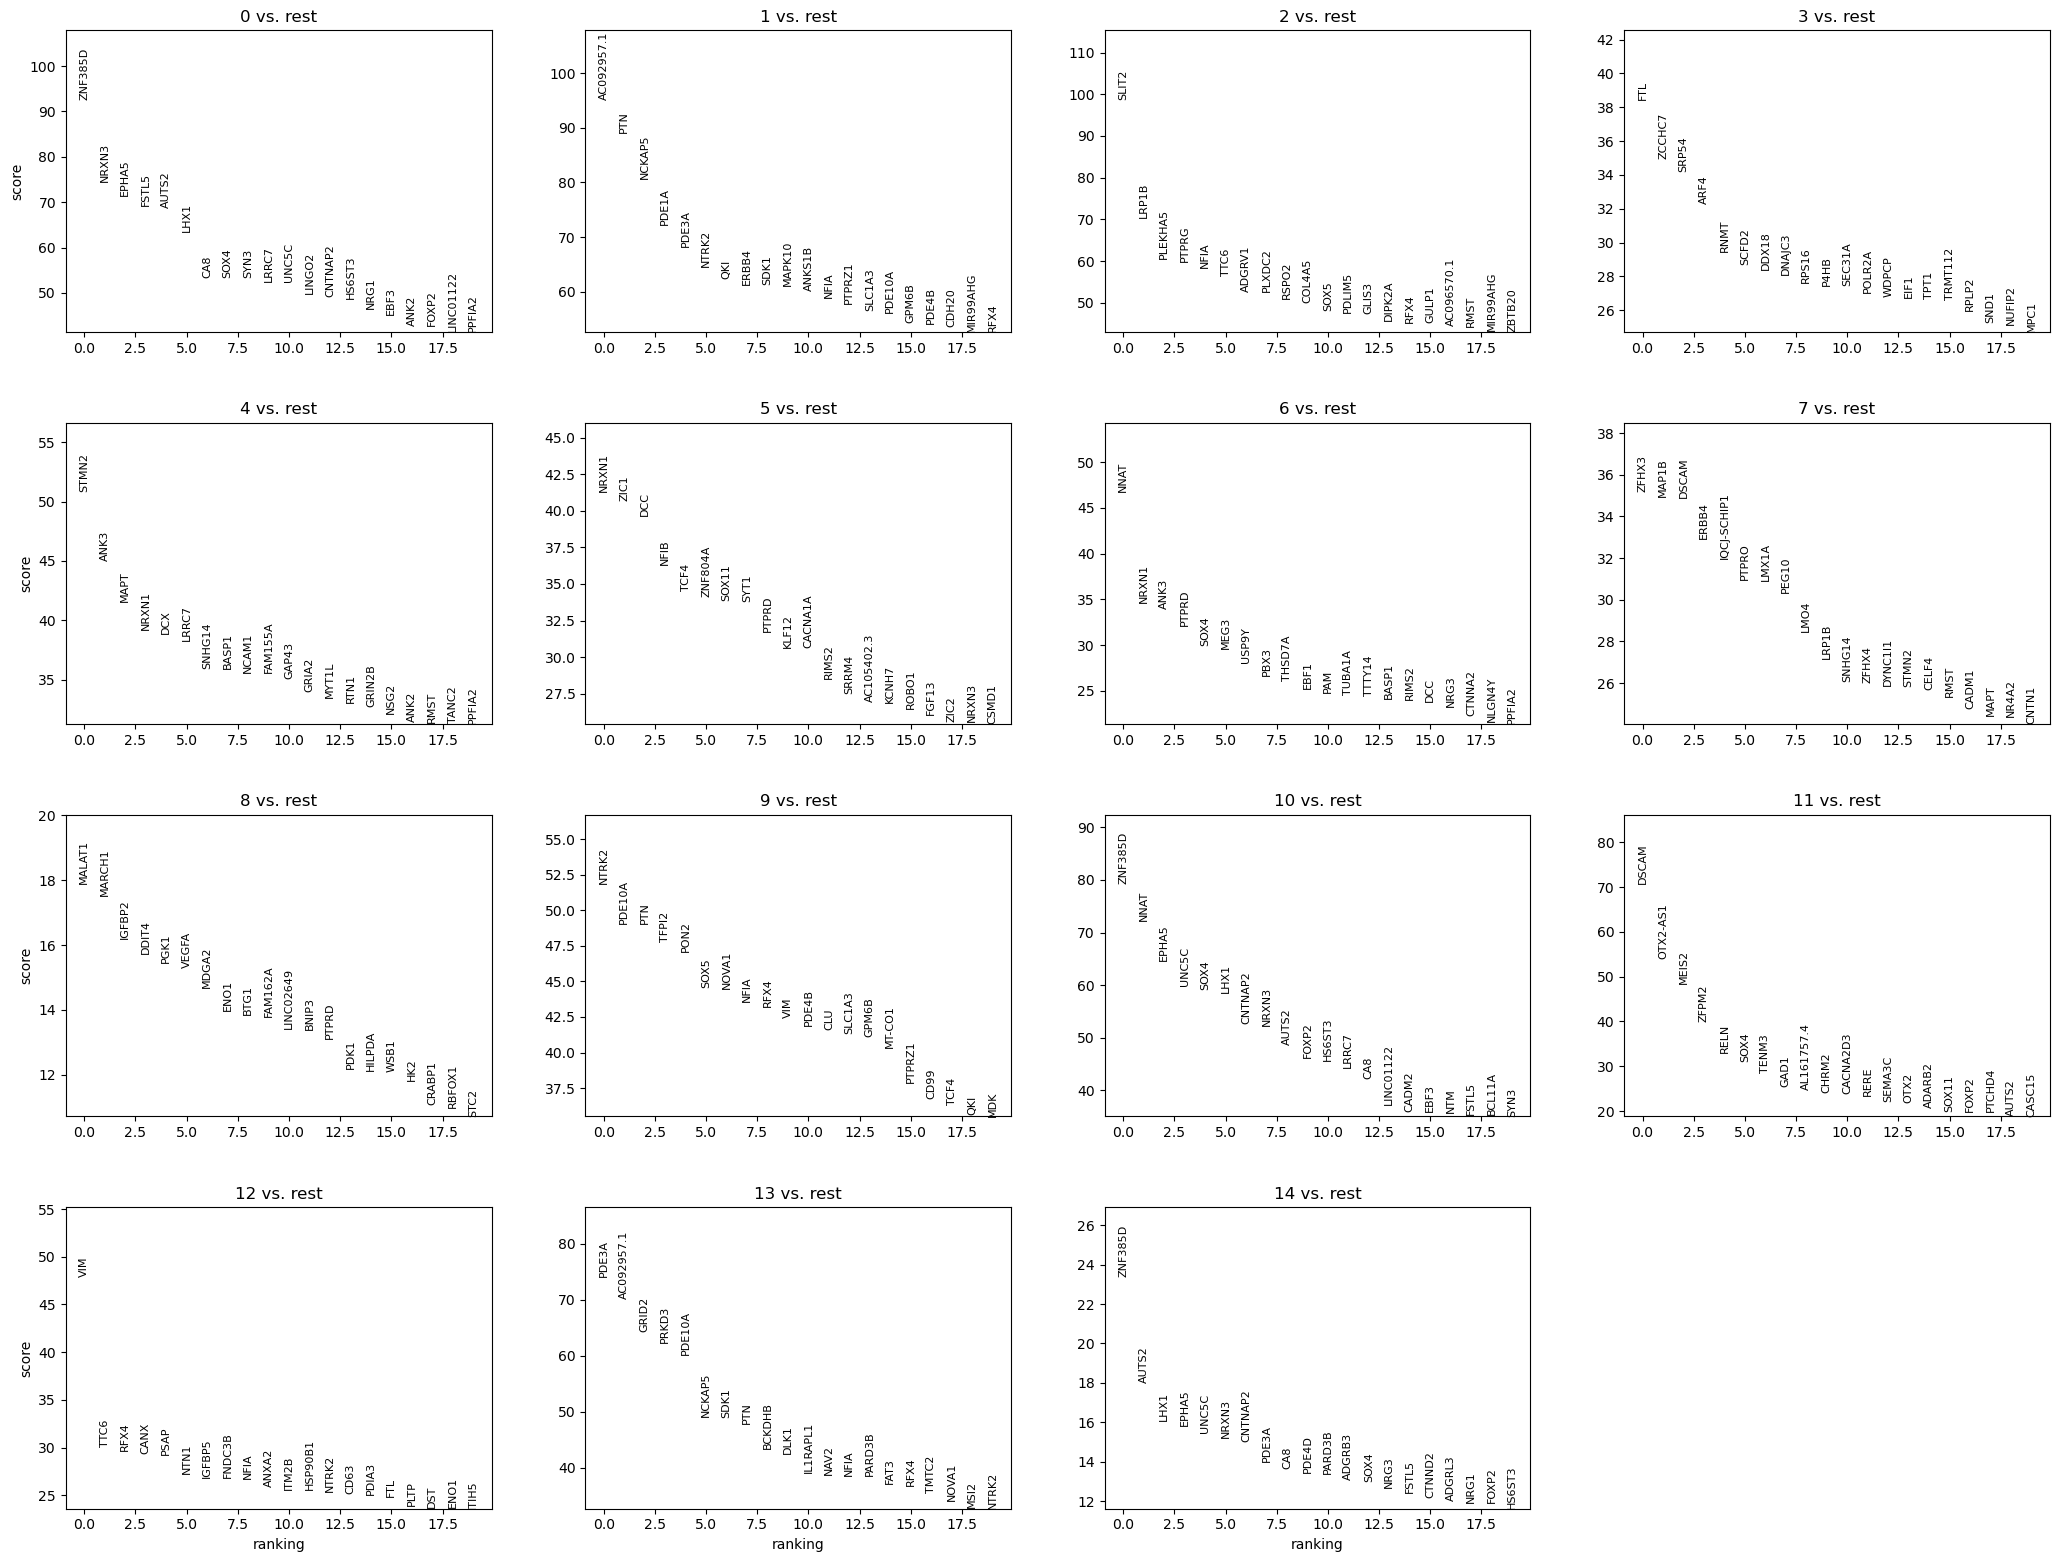

In [103]:
# Lets look at top 20 genes defining each cluster
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

### Cell type annotation

To visualize canonical marker gene expression in clusters, feature plot may not be the most efficient and straightforward visualization. In this case, making a dot plot is probably more useful.

In [114]:
marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

In [118]:
list(marker_genes["1_n"])

['AC092957.1',
 'PTN',
 'NCKAP5',
 'PDE1A',
 'PDE3A',
 'NTRK2',
 'QKI',
 'ERBB4',
 'SDK1',
 'MAPK10']

categories: 0, 1, 2, etc.
var_group_labels: NPC, Neuroblast, Neuron, etc.


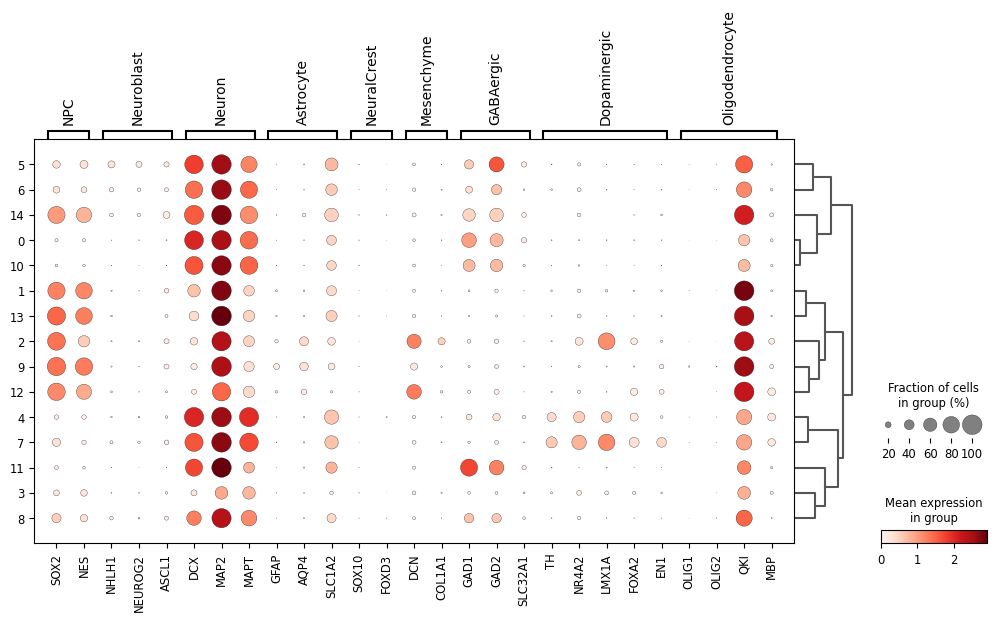

In [156]:
marker_genes_dict= {
    # Major Classes
    'NPC': ['SOX2', 'NES'],
    'Neuroblast': ['NHLH1', 'NEUROG2', 'ASCL1'],
    'Neuron': ['DCX', 'MAP2', 'MAPT'],
    'Astrocyte': ['GFAP', 'AQP4', 'SLC1A2'],
    'NeuralCrest': ['SOX10', 'FOXD3'],
    'Mesenchyme': ['DCN', 'COL1A1'],
    
    # Neuronal Subtypes
    #'Glutamatergic': ['SLC17A6', 'SLC17A7'],  # VGLUT2, VGLUT1
    'GABAergic': ['GAD1', 'GAD2', 'SLC32A1'],
    #'Purkinje': ['CA8', 'PCP4', 'GRID2'],
    'Dopaminergic': ['TH', 'NR4A2', 'LMX1A', 'FOXA2', 'EN1'],
    
    # Additional Specific Subtypes (optional granularity)
    #'Dopaminergic_Midbrain': ['FOXA2', 'NR4A2', 'EN1', 'LMX1A'],  # midbrain origin markers
    #'Dopaminergic_hDA1': ['TH', 'NR4A2', 'EN1', 'FOXA2'],
    # hDA2 not observed: ['ALDH1A1', 'LMO3']
    
    # Oligodendrocyte Lineage (not explicitly mentioned, but likely present)
    'Oligodendrocyte': ['OLIG1', 'OLIG2', 'QKI', 'MBP'],
    
}


# Here choose the resolution of choice, this will define the nu,ber of clusters we are annotating
sc.pl.dotplot(rna, marker_genes_dict, "leiden_res_0.5", dendrogram=True)

Since we are in. the midbrain most cell types are neurons, we would expect to observe: <br>
- Mature dopaminergic neurons
- Other neuronal subtypes (GABAergic, glutamatergic)
- Astrocytes and oligodendrocyte precursors
- A reduced pool of NPCs
- Possibly mesenchymal or contaminating neural crest-like cells

In [149]:
# Assign main clusters to main cell types
cluster2annotation = {
    "0": "GABAergic",
    "1": "NPC/Oligoden/Astro",
    "2": "Misc",
    "3": "Misc",
    "4": "Dopaminergic",
    "5": "GABAergic",
    "6": "GABAergic",
    "7": "Dopaminergic",
    "8": "GABAergic",
    "9": "NPC/Oligoden/Astro",
    "10": "GABAergic",
    "11": "?",
    "12": "NPC/Oligoden/Astro",
    "13": "NPC/Oligoden/Astro",
    "14": "GABAergic"
}
rna.obs["annot_ct"] = rna.obs["leiden_res_0.5"].map(cluster2annotation).astype("category").cat.reorder_categories(
    ["Dopaminergic", "GABAergic", "NPC/Oligoden/Astro", "Misc", "?"])

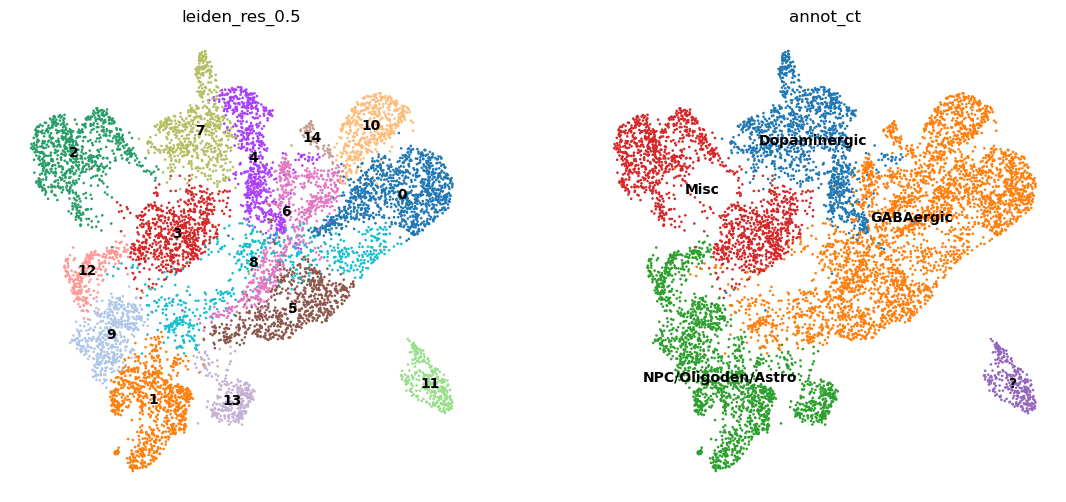

In [150]:
# Plot the results with annotations
with plt.rc_context({'figure.figsize':(6,6)}):
    sc.pl.umap(rna, color=['leiden_res_0.5','annot_ct'], frameon=False, legend_loc='on data')

We see that clusters 2, 3 and 11, 13 are not so trivial to assign, so we might look deeper into the genes that are expressed there.

## Individual analysis of scATAC-seq data 
- 2D embedding (e.g., UMAP or t-SNE)

- The general procedure of analyzing an ATAC assay is actually quite similar to the RNA counterpart. The steps include feature selection, data normalization, linear dimension reduction, non-linear dimension reduction for visualization, clustering and annotation, and marker identification.

### Preprocessing ATAC: QC and normalization

In [4]:
from muon import atac as ac

In [5]:
atac = mdata.mod['atac']
atac
# 246883 peaks identified
# 8656 cells

AnnData object with n_obs × n_vars = 8656 × 246883
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [6]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

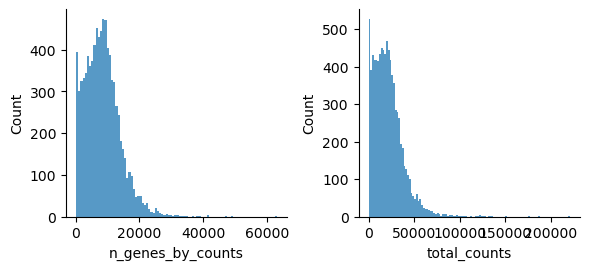

In [7]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

Filter peaks where accessibility is not detected: 

- “n_genes_by_counts”. The number of genes with at least 1 count in a cell. Calculated for all cells. &#9658; get rid of genes with very low or very high counts
  
- “total_counts”. Sum of counts for a gene.

In [8]:
# We filter out peaks that are accessible in less than 10 cells
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [15]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
print(f"(After total_counts: {atac.n_obs} cells)")
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))
print(f"After: {atac.n_obs} cells")

Before: 8598 cells
(After total_counts: 8317 cells)
After: 8317 cells


Let's see how the data looks after filtering:

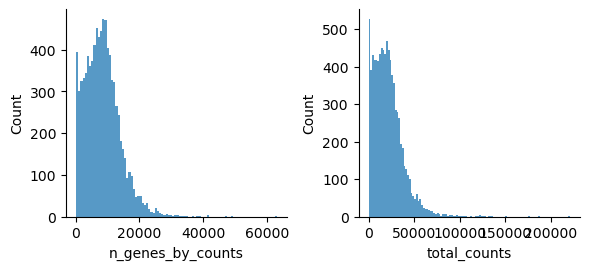

In [9]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

For the ATAC assay one cell (at least for a normal human cell) contains only two copies of DNA, and a __certain genomic region in one cell is either accessible or inaccessible in each of the two copies__. This makes the accessibility levels rather discrete than continuous. Therefore, instead of using the variantion-based feature selection methods, the even simplier method is usually used for ATAC assay, which is to __select peaks being detected in sufficient number of cells in the data__. Here the number can be a fixed numeric number, or the percentile of peaks in terms of how commonly detected it is across cells. The selected features are therefore called "top features" instead of "variable features".

### Nucleosome signal

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

Fetching Regions...: 100%|█████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


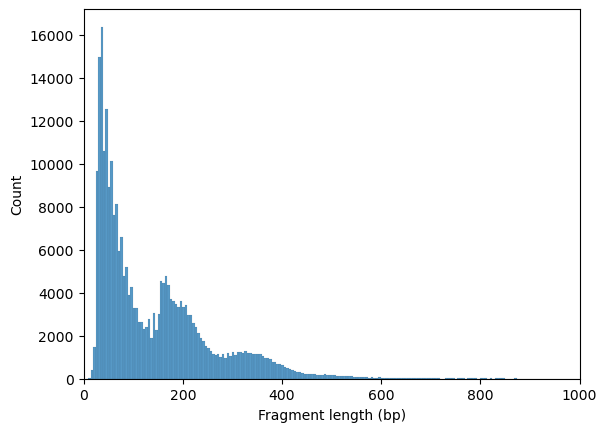

In [13]:
ac.pl.fragment_histogram(atac, region='chr7:1-2000000')

We can also quantify the approximate ratio of ATAC fragments with a strong nucleosome banding pattern (those with fragment lengths around a single nucleosome) that unlikely represent real accessible genomic regions, in relative to the nucleosome-free fragments, and then discard cells with too high of such ratio.The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called *nucleosome signal*, and it can be estimated using a subset of fragments.

Reading Fragments: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:03<00:00, 252968.47it/s]


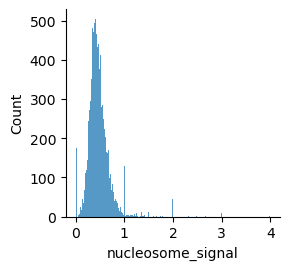

In [11]:
ac.tl.nucleosome_signal(atac, n=1e6)
mu.pl.histogram(atac, "nucleosome_signal", linewidth=0)

In [12]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'nucleosome_signal', lambda x: x < 2)
print(f"(After nucleosome_signal: {atac.n_obs} cells)")

Before: 8656 cells
(After nucleosome_signal: 8598 cells)


In [15]:
atac

AnnData object with n_obs × n_vars = 8343 × 246784
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

### TSS enrichment

We should exclude cells with too weak fragment enrichment around the transcriptional start sites (TSS). We can expect chromatin accessibility enriched around __transcription start sites (TSS)__ compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric. <p>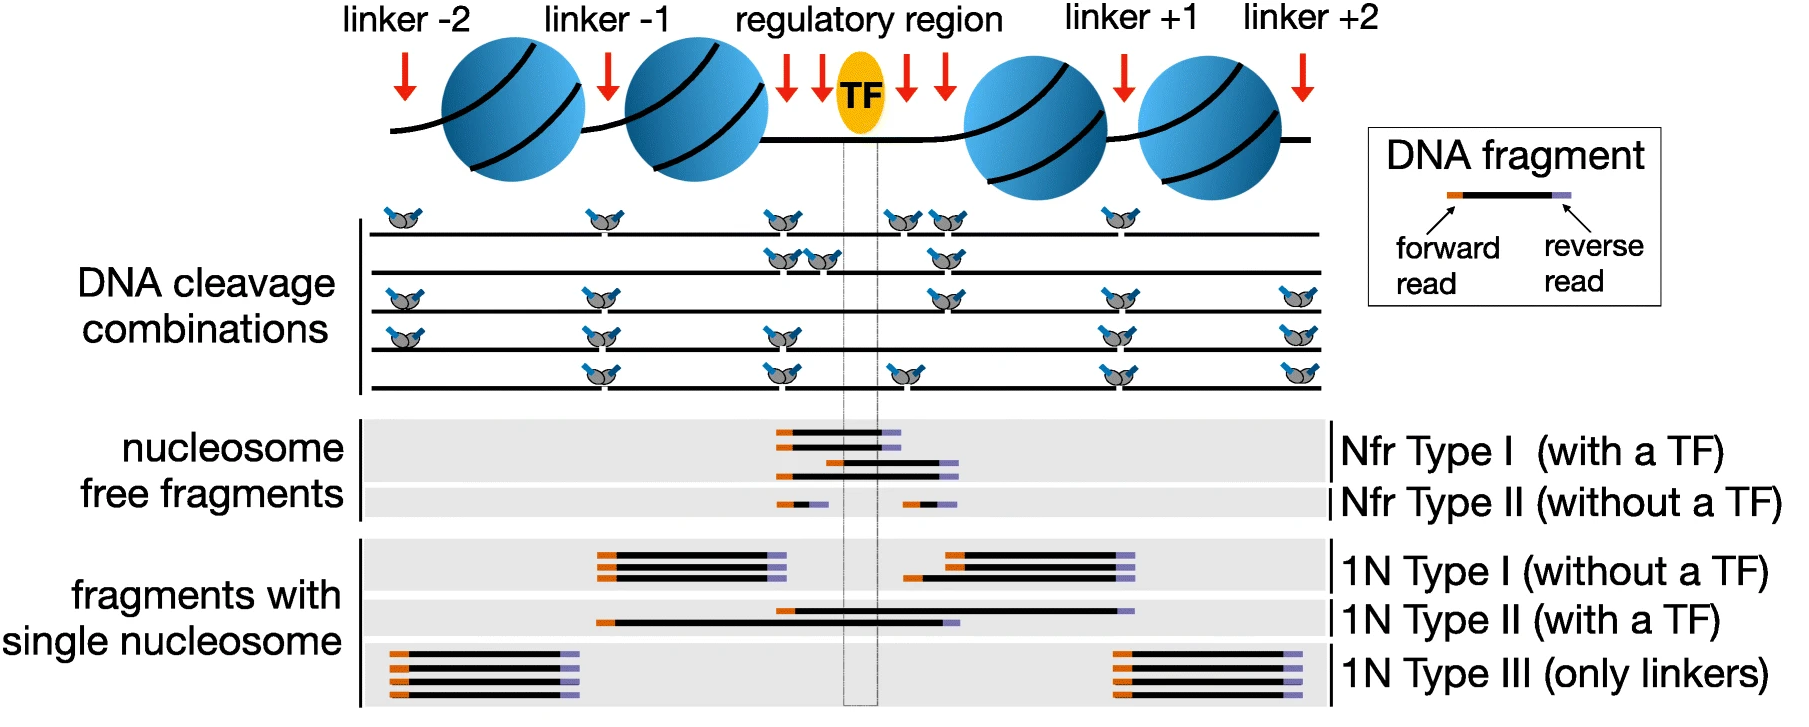

In [13]:
# We first need to know where the TSS are annotated in the genome
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(10)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

Chromosome   Start     End          gene_id    gene_name
MIR1302-2HG       chr1   29553   30267  ENSG00000243485  MIR1302-2HG
FAM138A           chr1   36080   36081  ENSG00000237613      FAM138A
OR4F5             chr1   65418   69055  ENSG00000186092        OR4F5
AL627309.1        chr1  120931  133723  ENSG00000238009   AL627309.1
AL627309.3        chr1   91104   91105  ENSG00000239945   AL627309.3
AL627309.2        chr1  140338  140339  ENSG00000239906   AL627309.2
AL627309.5        chr1  149706  173862  ENSG00000241860   AL627309.5
AL627309.4        chr1  160445  160446  ENSG00000241599   AL627309.4
AP006222.2        chr1  266854  266855  ENSG00000286448   AP006222.2
AL732372.1        chr1  360056  360057  ENSG00000236601   AL732372.1

TSS enrichment function will return an AnnData object with `cells x bases` dimensions where `bases` correspond to positions around TSS and are defined by `extend_upstream` and `extend_downstream` parameters, each of them being 1000 bp by default. It will also record `tss_score` in the original object.

In [16]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)
tss

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.90it/s]
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8317 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

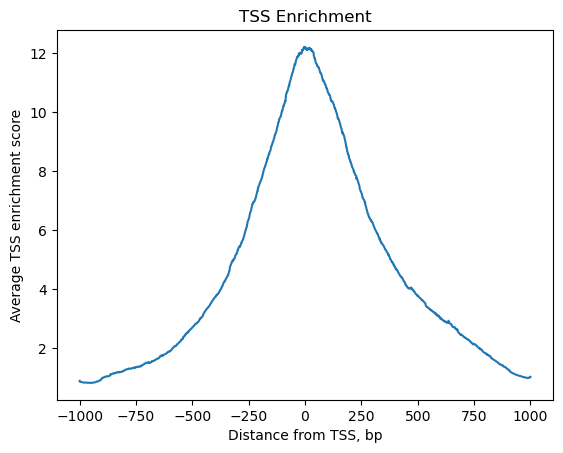

In [22]:
ac.pl.tss_enrichment(tss)

In [24]:
atac

AnnData object with n_obs × n_vars = 8317 × 246784
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [17]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'tss_score', lambda x: x > 1)
print(f"(After tss_score: {atac.n_obs} cells)")

Before: 8317 cells
(After tss_score: 8138 cells)


### Normalisation
Transform peak counts with TF-IDF (Term Frequency - Inverse Document Frequency).

TF: peak counts are normalised by total number of counts per cell DF: total number of counts for each peak IDF: number of cells divided by DF

By default, log(TF) * log(IDF) is returned.

muon.atac.pp.tfidf(data: AnnData | MuData, log_tf: bool = True, log_idf: bool = True, log_tfidf: bool = False, scale_factor: int | float = 10000.0, inplace: bool = True, copy: bool = False, from_layer: str | None = None, to_layer: str | None = None)

In [58]:
#atac.layers["counts"] = atac.X.copy()

# Apply TF-IDF normalization
#ac.pp.tfidf(atac, scale_factor=1e4)

ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

In [18]:
# Since that doesnt work we do normalisation as previously with RNAseq
atac.layers["counts"] = atac.X.copy()
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers["lognorm"] = atac.X.copy()

### Feature selection | Define informative features

In [19]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

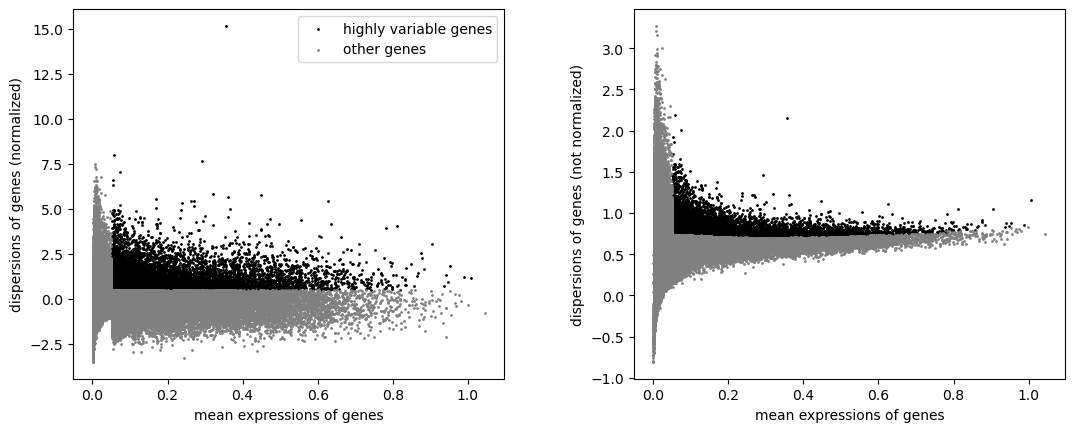

In [20]:
sc.pl.highly_variable_genes(atac)

In [21]:
np.sum(atac.var.highly_variable)
# We have 9653 highly variable genes

np.int64(9690)

### Scaling and PCA

In [33]:
sc.pp.scale(atac, max_value=10)
# maybe dont because this took very long

In [34]:
sc.tl.pca(atac, svd_solver='arpack')

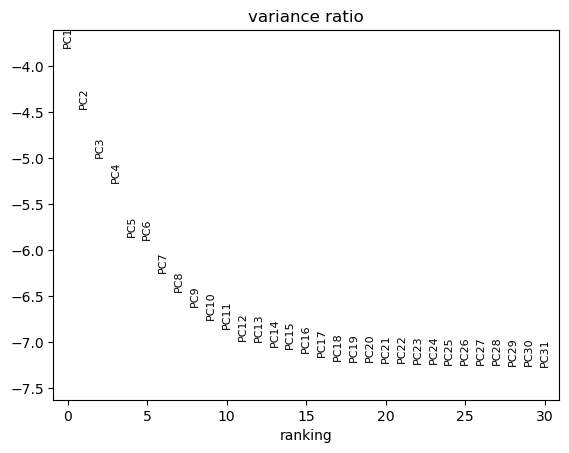

In [25]:
sc.pl.pca_variance_ratio(atac, log=True)

### Finding cell neighbours and clustering cells

In [26]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)

In [27]:
sc.tl.leiden(atac, resolution=.5)

/var/folders/kx/wqvq3yrs4hd7184jmlbcpzd80000gn/T/ipykernel_15876/937485634.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, resolution=.5)


### Non-linear dimensionality reduction

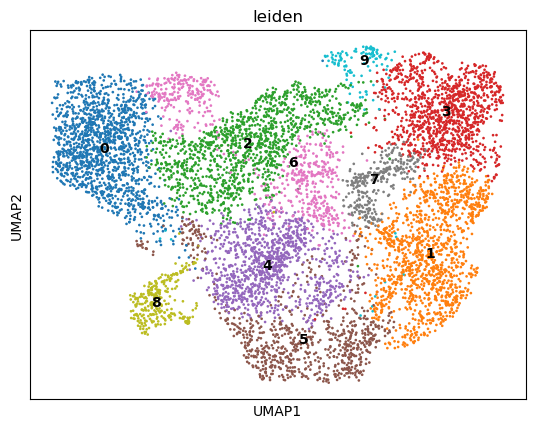

In [28]:
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(atac, color="leiden", legend_loc="on data")

### Marker genes and cell types

In [29]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [30]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names

try:
    pd.set_option("max_columns", 50)
except:
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
    pd.set_option("display.max_columns", 50)

pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

0_n               0_g            0_p  \
0     chr2:24435305-24436206        AC093798.1  2.407732e-181   
1   chr1:212515133-212516053        AC092803.2  3.100653e-170   
2    chr16:81657762-81658666              CMIP  3.476544e-163   
3    chr11:75338466-75339396             ARRB1  1.438020e-163   
4   chr7:106895967-106896880            PIK3CG  9.626548e-159   
5    chr17:46929333-46930220             GOSR2  3.599451e-155   
6       chr7:3979425-3980311  AC017000.1, SDK1  7.696313e-154   
7    chr14:74257506-74258442              VSX2  5.317509e-154   
8  chr12:113161220-113162107     DDX54, CFAP73  3.657387e-150   
9    chr13:96851578-96852487            HS6ST3  3.967099e-144   

                         1_n                 1_g            1_p  \
0  chr11:114294662-114295600    AP002518.2, NNMT  5.345951e-106   
1    chr11:74672786-74673710              CHRDL2  1.378129e-105   
2     chr3:13811849-13812786               WNT7A  3.552781e-103   
3    chr17:45092773-45093668                NMT1   4.812109e-98   
4   chr8:126588533-126589428       LRATD2, PCAT1   8.319915e-95   
5   chr8:143823113-143823997               PUF60   4.098593e-94   
6    chr15:67915282-67916086          AC009292.1   4.652307e-93   
7  chr12:124422604-124423520               NCOR2   3.547294e-90   
8   chr2:240972887-240973787  AC104809.2, CROCC2   1.704299e-88   
9    chr15:70474697-70475662           LINC02205   8.942334e-88   

                         2_n                 2_g            2_p  \
0    chr18:51654467-51655339           LINC01630  1.046325e-101   
1     chr1:21254123-21254976    ECE1, AL031005.1  1.223914e-101   
2  chr10:128568834-128569726                       3.730792e-96   
3     chr8:55631523-55632402          AC090200.1   2.863232e-88   
4  chr13:110499507-110500425  COL4A2, COL4A2-AS1   1.181039e-85   
5    chr16:27529843-27530733              GTF3C1   1.103941e-83   
6     chr2:48195913-48196839          AC092650.1   8.267205e-82   
7       chr8:8503246-8504185          AC103957.2   4.012632e-82   
8   chr5:174283197-174284095          AC025752.1   1.716336e-81   
9   chr6:137431941-137432850               OLIG3   2.101206e-79   

                         3_n                   3_g            3_p  \
0     chr9:81826169-81827027            AL591368.1  2.183672e-152   
1    chr13:51246357-51247296               FAM124A  2.514195e-149   
2   chr1:162248701-162249610    NOS1AP, AL512785.1  6.943868e-139   
3   chr6:164085167-164086074              Z97205.2  2.605243e-134   
4    chr13:94706480-94707332  LINC00391, SOX21-AS1  9.556401e-133   
5    chr15:45326336-45327317           AC051619.11  5.334644e-131   
6     chr3:45509005-45509892      LARS2-AS1, LARS2  6.599153e-129   
7  chr11:121696049-121696994            AP001977.1  9.665861e-128   
8     chr3:13811849-13812786                 WNT7A  1.674407e-127   
9  chr11:107699438-107700341                   SLN  3.508128e-123   

                         4_n               4_g           4_p  \
0       chrX:1452686-1453617             ASMTL  6.581914e-37   
1    chr20:18983817-18984697        AL135936.1  1.490638e-35   
2     chr1:59814316-59815230             HOOK1  6.876474e-31   
3   chr1:165288325-165289280             LMX1A  4.651254e-28   
4   chr5:179439264-179440184        AC136628.1  5.936618e-28   
5      chr11:2171461-2172381                TH  7.384543e-28   
6  chr12:111405301-111406222             SH2B3  1.112728e-26   
7     chr2:25376517-25377412  DTNB, AC012074.1  1.320266e-26   
8  chr11:126465447-126466372  KIRREL3, ST3GAL4  6.290632e-26   
9     chr3:10702690-10703572            ATP2B2  8.852028e-26   

                         5_n                   5_g            5_p  \
0       chr3:4978470-4979528  BHLHE40-AS1, BHLHE40  1.352681e-115   
1   chr8:102806323-102807198                GASAL1   4.717131e-92   
2      chr19:7870104-7870928     AC010336.3, PRR36   6.122974e-89   
3       chr6:6008473-6009468                  NRN1   2.203169e-82   
4    chr17:44137846-441

In [32]:
marker_genes_dict= {
    # Major Classes
    'NPC': ['SOX2', 'NES'],
    'Neuroblast': ['NHLH1', 'NEUROG2', 'ASCL1'],
    'Neuron': ['DCX', 'MAP2', 'MAPT'],
    'Astrocyte': ['GFAP', 'AQP4', 'SLC1A2'],
    'NeuralCrest': ['SOX10', 'FOXD3'],
    'Mesenchyme': ['DCN', 'COL1A1'],
    
    # Neuronal Subtypes
    #'Glutamatergic': ['SLC17A6', 'SLC17A7'],  # VGLUT2, VGLUT1
    'GABAergic': ['GAD1', 'GAD2', 'SLC32A1'],
    #'Purkinje': ['CA8', 'PCP4', 'GRID2'],
    'Dopaminergic': ['TH', 'NR4A2', 'LMX1A', 'FOXA2', 'EN1'],
    
    # Additional Specific Subtypes (optional granularity)
    #'Dopaminergic_Midbrain': ['FOXA2', 'NR4A2', 'EN1', 'LMX1A'],  # midbrain origin markers
    #'Dopaminergic_hDA1': ['TH', 'NR4A2', 'EN1', 'FOXA2'],
    # hDA2 not observed: ['ALDH1A1', 'LMO3']
    
    # Oligodendrocyte Lineage (not explicitly mentioned, but likely present)
    'Oligodendrocyte': ['OLIG1', 'OLIG2', 'QKI', 'MBP'],
    
}


# Here choose the resolution of choice, this will define the nu,ber of clusters we are annotating
sc.pl.dotplot(atac, marker_genes_dict, "leiden", dendrogram=True)

KeyError: "Could not find keys [np.str_('AQP4'), np.str_('ASCL1'), np.str_('COL1A1'), np.str_('DCN'), np.str_('DCX'), np.str_('EN1'), np.str_('FOXA2'), np.str_('FOXD3'), np.str_('GAD1'), np.str_('GAD2'), np.str_('GFAP'), np.str_('LMX1A'), np.str_('MAP2'), np.str_('MAPT'), np.str_('MBP'), np.str_('NES'), np.str_('NEUROG2'), np.str_('NHLH1'), np.str_('NR4A2'), np.str_('OLIG1'), np.str_('OLIG2'), np.str_('QKI'), np.str_('SLC1A2'), np.str_('SLC32A1'), np.str_('SOX10'), np.str_('SOX2'), np.str_('TH')] in columns of `adata.obs` or in adata.var_names."